# Time evolution of the Joint distribution $P(m, p; t)$

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [129]:
import os
import dill
import itertools

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages # to save multipage pdf
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_joint/'
datadir = '../../data/csv_maxEnt_dist/'

### $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{avg}[1]{\left\langle #1 \right\rangle}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
---

# Dynamics of gene expression.

So far we have determined how to compute the dynamics of the distribution moments $\ee{m^xp^y}(t)$. We also developed a MaxEnt approach to approximate the distribution $P(m, p)$ based on these moments. In this notebook we will combine both approaches to generate a numerical approximation of the time evolution of the distribution $P(m, p; t)$.

## Dynamics of induction

As a first exercise we will compute the dynamics of a strain after being induced. For this we will assume that the cells were at steady state when the inducer concentration $c$ was zero. At time $t_o$ the media was spiked with an inducer concentration $c = c_o$ (which we will take as saturated concentrations of inducer) and we will track over time how does the joint distribution $P(m, p; t)$ evolve.

### Finding the initial conditions
To compute these dynamics we first need to find the inital conditions of the system. These will be the steady-state values of the uninduced distribution. We will do this using the `dpdt` function that we generated to compute time evolution of the moments rather than our analytical results for the steady state expression because the initial conditions for our numerical integration of the moment equations require not the global moments, i.e. the sum of the moments on each promoter state, but the individual contributions of each promoter state. In other words we do not need to know $\ee{\bb{m}(t_o)}$ but the three components of this moment $\left[ \ee{m_P(t_o)}, \ee{m_E(t_o)}, \ee{m_R(t_o)} \right]$.

For this we need to define the parameters for the regulated promoter.
We will specifically focus on the **O2 R260** strain as our example.

In [2]:
# List the parameters fit for the lacUV5 regulated promoter
par_UV5_reg = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                 Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5)

# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par_UV5_reg['k0'] = k0_norm

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5_reg['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5_reg['rp'] = 1000 * par_UV5_reg['gp']

# Add repressor copy number and binding energy
par = par_UV5_reg.copy()
par['rep'] = 260 # repressors / cell
par['eRA'] = -13.9  # kBT

print(par)

{'kp_on': 5.5, 'kp_off': 28.9, 'rm': 87.6, 'gm': 1, 'Nns': 4600000.0, 'ka': 139, 'ki': 0.53, 'epsilon': 4.5, 'k0': 0.9507042253521127, 'gp': 0.09753521126760563, 'rp': 97.53521126760563, 'rep': 260, 'eRA': -13.9}


Now let's define a function to build the matrices necessary for the numerical integration of the moment equations.

In [3]:
def cme_matrix_gen(C, rep, eRA,
                   k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
                   rp=0.0975, gp=97.53,
                   Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Given the parameters in the master equation it returns the matrices K, R_m,
    G_m, R_p and G_p for transition between states, production and degradation
    of both mRNA and protein.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg: 2D-array. 3 x 3 matrices.
        Matrices necessary for the integration of the moment dynamics.
        Km_reg : state transition matrix.
        Rm_reg : Production matrix for mRNA 
        Gm_reg : Degradation matrix for mRNA 
        Rp_reg : Production matrix for protein
        Gp_reg : Degradation matrix for protein
    '''
    # Calculate the repressor on rate including the MWC model
    kr_on = k0_norm * rep * chann_cap.p_act(C, ka, ki, epsilon) 
    kr_off = chann_cap.kr_off_fun(eRA, k0_norm, kp_on, kp_off, Nns)
    
    # Define the production matrix
    Rm_reg = np.array([[rm, 0, 0],
                       [0, 0, 0],
                       [0, 0, 0]])
    # Define the degradation matrix
    Gm_reg = np.array([[gm, 0, 0],
                       [0, gm, 0],
                       [0, 0, gm]])

    # Define the production matrix
    Rp_reg = np.array([[rp, 0, 0],
                       [0, rp, 0],
                       [0, 0, rp]])

    # Define the production matrix
    Gp_reg = np.array([[gp, 0, 0],
                       [0, gp, 0],
                       [0, 0, gp]])

    # Define the state transition matrix
    Km_reg = np.array([[-kp_off, kp_on, 0], 
                       [kp_off, -(kp_on + kr_on), kr_off],
                       [0, kr_on, -kr_off]])
    
    return Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg

Having this function we can generate the matrices assuming an initial concentration $C_o = 0$ µM IPTG.

To obtain the initial conditions we will integrate for a long time and keep the last point as the initial condition for our simulation. Let's define a function that returns this initial condition given the parameters of the master equation.

In [4]:
def init_cond(C, rep, eRA, 
              k0=2.7E-3, kp_on=5.5, kp_off=28.9, rm=87.6, gm=1,
              rp=0.0975, gp=97.53,
              Nns=4.6E6, ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the initial conditions for all the inidividual moments as a
    function of the parameters in the master equation and an initial inducer
    concentration by integrating in the long time limit the moment equations
    and taking the final time point as the initial condition.
    
    Parameters
    ----------
    moment_fun : list.
        List containing the functions to be used to compute the steady
        state moments.
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    init_cond : array-like.
        Value of the initial conditions for each of the inidividual moments.
    
    '''
    # Extract input argumest as dictionary
    par = locals()
    # Obtain matrices for inital conditions
    Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg = cme_matrix_gen(**par) 
    
    # Define time on which to perform integration
    t = np.linspace(0, 100, 300)

    # Define initial conditions
    m0_init = [0.3, 0.3, 0.4]
    m1_init = [0, 0, 0]
    m2_init = [0, 0, 0]
    m3_init = [0, 0, 0]
    p1_init = [0, 0, 0]
    mp_init = [0, 0, 0]
    p2_init = [0, 0, 0]
    m2p_init = [0, 0, 0]
    mp2_init = [0, 0, 0]
    p3_init = [0, 0, 0]

    # Integrate dynamics
    sol = sp.integrate.odeint(chann_cap.dpdt, 
                              m0_init + m1_init + m2_init + m3_init +\
                              p1_init + mp_init + p2_init + m2p_init +\
                              mp2_init + p3_init,
                              t,
                              args=(Km_reg, Rm_reg, Gm_reg,
                                    Rp_reg, Gp_reg))

    # return last point as initial conditions
    return sol[-1, :]

Now let's obtain the initial conditions for an system in the absence of inducer.

In [5]:
sim_init = init_cond(0, **par)
# Print global moments.
sim_init.reshape(-1, 3).sum(axis=1)

array([  1.00000000e+00,   3.72059765e-01,   1.61381193e+00,
         1.16813282e+01,   3.72041674e+02,   2.72982681e+02,
         2.73347992e+05,   1.00291335e+03,   2.51522107e+05,
         2.52064484e+08])

### Integrating dynamics after induction.

Now that we have the initial conditions for our induction simulation, let's compute the dynamics assuming that we spark a high concentration of inducer into the media.

In [6]:
# Define time on which to perform integration
t = np.linspace(0, 45, 45)

# Define concentration after induction
c1 = 5000 # µM IPTG

Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg = cme_matrix_gen(c1, **par) 

# Integrate dynamics with new initial conditions
sol = sp.integrate.odeint(chann_cap.dpdt, sim_init, t,
                          args=(Km_reg, Rm_reg, Gm_reg,
                                Rp_reg, Gp_reg))

# Convert solution to tidy DataFrame
df = chann_cap.dynamics_to_df(sol, t)
df.head()

,time,m1,m2,m3,p1,mp,p2,m2p,mp2,p3
0,0.000000,0.372060,1.613812,11.681328,372.041674,272.982681,2.733480e+05,1002.913348,2.515221e+05,2.520645e+08
1,1.022727,7.552243,89.106997,1333.073351,702.734699,6659.324166,7.108151e+05,62143.217163,6.312324e+06,7.825563e+08
2,2.045455,11.245854,166.542447,2970.900043,1560.398896,20319.963904,3.003491e+06,226179.672149,3.500148e+07,5.475504e+09
3,3.068182,12.576912,200.126895,3771.990288,2554.718523,35579.635944,7.566866e+06,397346.706489,9.243576e+07,2.034995e+10
4,4.090909,13.055584,212.945420,4090.331622,3533.106321,49853.310262,1.398997e+07,542271.786881,1.724625e+08,4.946720e+10


For comparison let's compute the global steady-state moments with the analytical expressions using these parameters.

In [7]:
# List the functions
moment_fun = [chann_cap.first_reg_m,
              chann_cap.second_reg_m,
              chann_cap.third_reg_m,
              chann_cap.first_reg_p,
              chann_cap.second_reg_p,
              chann_cap.third_reg_p]

# Define names of dataframe index
names = ['m1', 'm2', 'm3', 'p1', 'p2', 'p3']

ss_moments = chann_cap.moment_ss_reg(moment_fun, c1, **par)
df_ss = pd.Series(ss_moments, index=names)
df_ss

m1    1.332439e+01
m2    2.203156e+02
m3    4.276364e+03
p1    1.332439e+04
p2    1.814533e+08
p3    2.305165e+12
dtype: float64

Let's look at the moment dynamics.

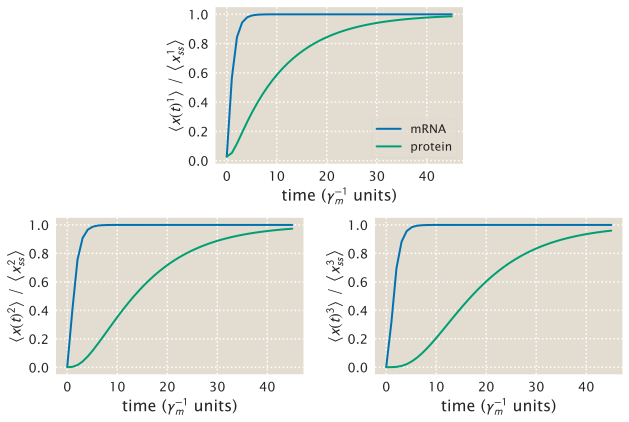

In [8]:
# Initialize figure
fig = plt.figure(figsize=(9, 6))

# Define axis to have two on the bottom and one on the top
ax = list()
ax.append(plt.subplot2grid((2, 4), (0, 1), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 0), colspan=2, rowspan=1))
ax.append(plt.subplot2grid((2, 4), (1, 2), colspan=2, rowspan=1))

# Define array with names of moments to plot
moments_m = ['m1', 'm2', 'm3']
moments_p = ['p1', 'p2', 'p3']

# Loop through groups
for i in range(len(moments_m)):
    # Plot moments moment
    ax[i].plot(df['time'], df[moments_m[i]] / df_ss[moments_m[i]],
              label='mRNA')
    ax[i].plot(df['time'], df[moments_p[i]] / df_ss[moments_p[i]],
              label='protein')
    
    # Label axis
    ax[i].set_xlabel('time ($\gamma_m^{-1}$ units)')
    ax[i].set_ylabel(r'$\left\langle x(t)^{:d} \right\rangle$ / '.format(i+1) +\
                     r'$\left\langle x_{{ss}}^{:d} \right\rangle$'.format(i+1))
    
# Include legend
ax[0].legend(fontsize=12)

plt.tight_layout()

Everything seems to be working adequately since the dynamics are converging to the predicted steady-state value in a coherent time scale. Time to compute the distribution dynamics using the MaxEnt approach.

# Fitting the MaxEnt distribution for each time point.

We now have the dynamics of the distribution moments in hand. With this we can find the value of the Lagrange multipliers associated with the MaxEnt approximation.

Let's first define the mRNA and protein sample space and compute the features required by the `maxentropy` package in order to fit the distribution.

In [9]:
# Define sample space
mRNA_space = np.arange(0, 40)
protein_space = np.arange(0, 2.3E4)
# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# List all functions used to compute the products associated with each of
# the constraints
feature_fun = [chann_cap.m1_fn, chann_cap.m2_fn, chann_cap.m3_fn,
               chann_cap.p1_fn, chann_cap.p2_fn, chann_cap.mp_fn]

# Initialize matrix to save all the features that are fed to the 
# maxentropy function
features = np.zeros([len(feature_fun), len(samplespace)])

# Loop through constraints and compute features
for i, feat in enumerate(feature_fun):
    features[i, :] = [feat(x) for x in samplespace]

Now let's loop through each of the time points, fitting the MaxEnt distribution each time.

In [21]:
# Initialize data frame to save the lagrange multipliers.
names = ['time', 'lambda_m1', 'lambda_m2', 'lambda_m3',
         'lambda_p1', 'lambda_p2', 'lambda_mp']
df_maxEnt = pd.DataFrame([], columns=names)

# Extract time from the moment dynamics
time = df['time'].values
# Define column names containing the constraints used to fit the distribution
constraints_names = ['m1', 'm2', 'm3', 'p1', 'p2', 'mp']


fit_dist = False
if fit_dist:
    # Define the minimum entropy 
    model = MinDivergenceModel(features, samplespace)
    model.algorithm = 'Powell'
    model.tol = 5E-5
    model.paramstol = 5E-5
    model.maxiter = 1000
    model.callingback = True
    
    # Loop through time points
    for i, t in enumerate(time):
        print('time-point: ', i)
        # Extract constraints
        constraints = df.loc[i][constraints_names].values
        # Change the dimensionality of the array
        X = np.reshape(constraints, (1, -1))
        # Fit the model
        model.fit(X)
        # Save Lagrange multipliers into dataframe
        series = pd.Series(np.append(t, model.params), index=names)
        df_maxEnt = df_maxEnt.append(series, ignore_index=True)
        # Save partial progress
        df_maxEnt.to_csv(datadir + 'O2_R260_lagrange_dynamics.csv')
        
    # Append the extra information about the dynamics
    df_maxEnt['operator'] = ['O2'] * len(time)
    df_maxEnt['binding_energy'] = np.repeat(par['eRA'], len(time))
    df_maxEnt['repressors'] = np.repeat(par['rep'], len(time))
    # Save final version of DataFrame
    df_maxEnt.to_csv(datadir + 'O2_R260_lagrange_dynamics.csv')

Now that we have all of the Lagrange multipliers we can compute whichever probability we want. Let's define a vectorized function that returns the 2D probability distribution given an mRNA and protein sample space along with a list of Lagrange Multipliers.

In [10]:
def maxEnt_from_lagrange(mRNA, protein, lagrange, 
                         exponents=[(1, 0), (2, 0), (3, 0), 
                                   (0, 1), (0, 2), (1, 1)], log=False):
    '''
    Computes the mRNA and protein joint distribution P(m, p) as approximated
    by the MaxEnt methodology given a set of Lagrange multipliers.
    Parameters
    ----------
    mRNA, protein : array-like.
        Sample space for both the mRNA and the protein.
    lagrange : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    exponents : list. leng(exponents) == len(lagrange)
        List containing the exponents associated with each constraint.
        For example a constraint of the form <m**3> has an entry (3, 0)
        while a constraint of the form <m * p> has an entry (1, 1).
    log : bool. Default = False
        Boolean indicating if the log probability should be returned.
    Returns
    -------
    Pmp : 2D-array. len(mRNA) x len(protein)
        2D MaxEnt distribution.
    '''
    # Generate grid of points
    mm, pp = np.meshgrid(mRNA, protein)
    
    # Initialize 3D array to save operations associated with each lagrange
    # multiplier
    operations = np.zeros([len(lagrange), len(protein), len(mRNA)])
    
    # Compute operations associated with each Lagrange Multiplier
    for i, expo in enumerate(exponents):
        operations[i, :, :] = lagrange[i] * mm**expo[0] * pp**expo[1]
    
    # check if the log probability should be returned
    if log:
        return np.sum(operations, axis=0) -\
               sp.special.logsumexp(np.sum(operations, axis=0))
    else:
        return np.exp(np.sum(operations, axis=0) -\
                      sp.special.logsumexp(np.sum(operations, axis=0)))

Let's now import the DataFrame witht the lagrange multipliers.

In [11]:
# Read the dataframe with the lagrange multipliers
df_maxEnt = pd.read_csv(datadir + 'O2_R260_lagrange_dynamics.csv', index_col=0)
df_maxEnt.head(3)

,time,lambda_m1,lambda_m2,lambda_m3,lambda_p1,lambda_p2,lambda_mp,operator,binding_energy,repressors
0,0.000000,-2.338170,0.290235,-0.013962,-0.002374,-3.675919e-07,0.000318,O2,-13.9,260
1,1.022727,-0.009560,-0.015883,0.000090,0.000464,-2.049268e-06,0.000237,O2,-13.9,260
2,2.045455,0.093853,-0.019482,0.000096,0.001554,-1.164259e-06,0.000177,O2,-13.9,260


Now let's generate an animated gif of the evolution of the distribution.

In [12]:
def joint_animated_gif(df, mRNA, protein, figname, delay=25, outdir=figdir):
    '''
    Generates an animated gif using ImageMagick for the different 
    distributions.
    '''
    # Loop through distributions
    for i, row in df.iterrows():
        # Determine title
        title = 'O2 - R260; time: {:.1f}'.format(row['time'])
        # Extract lagrange multipliers
        columns = [x for x in df.columns if 'lambda' in x]
        lagrange = row[columns].values
        Pmp = maxEnt_from_lagrange(mRNA_space, protein_space, lagrange)
        # Generate temporary png images
        fig = chann_cap.joint_marginal_plot(mRNA_space, protein_space, Pmp, 
                              xlabel='mRNA / cell', ylabel='protein / cell',
                              title=title)
        plt.savefig(outdir + 'tmp-{:02d}.png'.format(i),
                   bbox_inches='tight')
        plt.close()
    # Run ImageMagick to convert to png
    command = 'convert -layers OptimizePlus -delay {0:d} ' +\
              '{1:s}tmp-??.png '+\
              '-loop 0 {1:s}{2:s}.gif'
    os.system(command.format(delay, outdir, figname))
    # Remove temporary pngs
    os.system('rm {:s}tmp-*png'.format(outdir))

In [121]:
joint_animated_gif(df_maxEnt, mRNA_space, protein_space,
                   'O2_R260_dynamics', 30)

### Runing for multiple inducer concentrations.

Now that we have a stable code working for this amount of moments let's repeat this process for multiple IPTG concentrations.

First let's integrate the dynamics for all concentrations.

In [13]:
# Define time on which to perform integration
t = np.linspace(0, 45, 45)

# Define experimental concentrations in µM
IPTG_init = 0
IPTG = [0.1, 1, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 1000] # µM

# Define initial conditions
sim_init = init_cond(IPTG_init, **par)
print('initial conditions: done.')

# Initialize data frame to save moments
names = ['time', 'm1', 'm2', 'm3', 'p1', 'mp', 'p2', 'm2p', 'mp2', 'p3']
param_names = ['IPTG_init', 'IPTG_final', 'eRA', 'rep']
df_moments = pd.DataFrame([], columns=names + param_names)

# Loop through concentrations
for c in IPTG:
    # Generate matrices corresponding
    Km_reg, Rm_reg, Gm_reg, Rp_reg, Gp_reg = cme_matrix_gen(c, **par) 

    # Integrate dynamics with new initial conditions
    sol = sp.integrate.odeint(chann_cap.dpdt, sim_init, t,
                              args=(Km_reg, Rm_reg, Gm_reg,
                                    Rp_reg, Gp_reg))

    # Convert solution to tidy DataFrame
    df = chann_cap.dynamics_to_df(sol, t)
    
    # Add colums with parameters
    df['IPTG_init'] = [IPTG_init] * len(df)
    df['IPTG_final'] = [c] * len(df)
    df['eRA'] = [par['eRA']] * len(df)
    df['rep'] = [par['rep']] * len(df)
    
    # Append to global data frame
    df_moments = pd.concat([df_moments, df], ignore_index=True)
    print('concentration {:.2f} µM: done'.format(c))

initial conditions: done.
concentration 0.10 µM: done
concentration 1.00 µM: done
concentration 5.00 µM: done
concentration 7.50 µM: done
concentration 10.00 µM: done
concentration 25.00 µM: done
concentration 50.00 µM: done
concentration 75.00 µM: done
concentration 100.00 µM: done
concentration 250.00 µM: done
concentration 500.00 µM: done
concentration 1000.00 µM: done


In [66]:
# Initialize data frame to save the lagrange multipliers.
names = ['time', 'lambda_m1', 'lambda_m2', 'lambda_m3',
         'lambda_p1', 'lambda_p2', 'lambda_mp']
param_names = ['IPTG_init', 'IPTG_final', 'eRA', 'rep']
# df_maxEnt = pd.DataFrame([], columns=names + param_names)
df_maxEnt = pd.read_csv(datadir + 'O2_R260_lagrange_multi_dynamics.csv')

# Let's group the moments DataFrame by final concentration
df_group = df_moments.groupby('IPTG_final')

fit_dist = False
if fit_dist:
    # Let's loop through each of the concentrations
    for group, df in df_group:
        print('concentration {:.2f} µM'.format(group))
        # Extract time from the moment dynamics
        time = df['time'].values
        
        # Define column names containing the constraints used to 
        # fit the distribution
        constraints_names = ['m1', 'm2', 'm3', 'p1', 'p2', 'mp']

        # Define the minimum entropy model algorithm
        model = MinDivergenceModel(features, samplespace)
        model.algorithm = 'Powell'
        model.tol = 5E-5
        model.paramstol = 5E-5
        model.maxiter = 1000
        model.callingback = True

        # Loop through time points
        for i, t in enumerate(time):
            # Extract constraints
            constraints = df.iloc[i][constraints_names].values
            # Change the dimensionality of the array
            X = np.reshape(constraints, (1, -1))
            # Fit the model
            model.fit(X)
            # Save Lagrange multipliers into dataframe
            series = pd.Series(np.concatenate([np.array([t]), model.params,
                      df.IPTG_init.unique(), df.IPTG_final.unique(),
                      df.eRA.unique(), df.rep.unique()]),
                     index=names + param_names)
            df_maxEnt = df_maxEnt.append(series, ignore_index=True)
            # Save partial progress
            df_maxEnt.to_csv(datadir + 'O2_R260_lagrange_multi_dynamics.csv')
        print('done!')
    # Append the extra information about the dynamics
    df_maxEnt['operator'] = ['O2'] * len(df_maxEnt)
    # Save final version of DataFrame
    df_maxEnt.to_csv(datadir + 'O2_R260_lagrange_multi_dynamics.csv')

# Mutual information over time.

Now that we have the joint distribution dynamics for different input concentrations we can compute the mutual information between the input $c$ and either output $x \in \{m, p\}$. Recall that the mutual information is defined as
$$
I(c, x) \equiv \sum_c \sum_x P(c, x) \log_2 {P(c, x) \over P(c)P(x)}.
$$
By using the definition of conditional probability, i.e. $P(x \mid c) = P(c, x) / P(c)$ we can rewrite the mutual information as
$$
I(c, x) \equiv \sum_c \sum_x P(x \mid c)P(c) \log_2 {P(x \mid c) \over P(x)}.
$$
Since $P(x)$ is the marginal distribution of $x$ this can finally be expressed as
$$
I(c, x) \equiv \sum_c \sum_x P(x \mid c)P(c) \log_2 {P(x \mid c) \over
\sum_c P(x \mid c)P(c)},
$$
or more conveniently expressed
$$
I(c, x) \equiv \sum_c P(c) \sum_x \left[ P(x \mid c) \log_2 P(x \mid c) -
P(x \mid c) \log_2 \sum_c P(x \mid c)P(c)\right].
$$

We will apply this equation for each time point for both, mRNA and protein.

Let's define a function to compute this given an mRNA and protein sample space, a probability distribution for the input $c$ and a set of Lagrange multipliers values associated with each input.

In [77]:
def maxEnt_mutual_info(p_input, mRNA, protein, lagrange, 
                         exponents=[(1, 0), (2, 0), (3, 0), 
                                   (0, 1), (0, 2), (1, 1)], cutoff=1E-10):
    '''
    Computes the mutual information between input concentration and both,
    mRNA and protein as a function of the input PMF p_input, an mRNA and
    protein sample space and a series of Lagrange multipliers 
    corresponding to each input.
    
    Parameters
    ----------
    p_input : array-like.
        Inducer input probability distribution. 
        NOTE: The sum of all the elements in this array must add up to 1.
    mRNA, protein : array-like.
        Sample space for both the mRNA and the protein.
    lagrange : 2D-array. Dimension = len(p_input) x len(exponents)
        2D-array containing the value of the Lagrange multipliers associated
        with each of the constraints for each of the input values.
        NOTE: This matrix should contain on the ith row the Lagrange 
        multipliers corresponding to the ith input.
    exponents : list. leng(exponents) == len(lagrange)
        List containing the exponents associated with each constraint.
        For example a constraint of the form <m**3> has an entry (3, 0)
        while a constraint of the form <m * p> has an entry (1, 1).
    cutoff : float.
        necessary lower bound to determine when to ignore a term in the
        integral given the convention that 0 x log0 = 0.
    Returns
    -------
    MI : array-like.
       MI[0] : mutual information between input and mRNA.
       MI[1] : mutual information between input and protein.
    '''
    # Initialize matrix to save marginal distributions of mRNA and protein
    PmC = np.zeros([len(p_input), len(mRNA)])
    PpC = np.zeros([len(p_input), len(protein)])
    
    # Loop through each of the Lagrange multipliers to build the marginal
    # distributions for each concentration
    for i, l in enumerate(lagrange):
        # Build the joint distribution P(m, p | c)
        Pmp = maxEnt_from_lagrange(mRNA, protein, l, exponents)
        
        # Compute the marginals for both mRNA P(m | c) and protein P(p | c)
        PmC[i, :] = np.sum(Pmp, axis=0)
        PpC[i, :] = np.sum(Pmp, axis=1)
    
    # build the marginalizations over all c P(m) and P(c) by summing over c
    Pm = np.dot(p_input, PmC)
    Pp = np.dot(p_input, PpC)
    # Tile the marginal to facilitate the computation of P(x|p)logP(x)
    Pm_tile = np.tile(Pm, (len(p_input), 1))
    Pp_tile = np.tile(Pp, (len(p_input), 1))
   
    # Make P(m|C) * logP(m|C) making sure no log(0).
    PmC_log_PmC = np.zeros_like(PmC)
    PmC_log_PmC[PmC > cutoff] = PmC[PmC > cutoff] * np.log2(PmC[PmC > cutoff])
    
    # Make P(m|C) * logP(m) making sure no log(0).
    PmC_log_Pm = np.zeros_like(PmC)
    PmC_log_Pm[Pm_tile > cutoff] = \
            PmC[Pm_tile > cutoff] * np.log2(Pm_tile[Pm_tile > cutoff])
    
    # Sum over m
    sum_m = np.sum(PmC_log_PmC - PmC_log_Pm, axis=1)
    
    # Sum over input to compute mutual info
    MI_mC = np.dot(p_input, sum_m)
    
    # Make P(p|C) * log(P(p|C)) making sure no log(0).
    PpC_log_PpC = np.zeros_like(PpC)
    PpC_log_PpC[PpC > cutoff] = PpC[PpC > cutoff] * np.log2(PpC[PpC > cutoff])
    
    # Make P(p|C) * log(P(p)) making sure no log(0).
    PpC_log_Pp = np.zeros_like(PpC)
    PpC_log_Pp[Pp_tile > cutoff] = \
            PpC[Pp_tile > cutoff] * np.log2(Pp_tile[Pp_tile > cutoff])
        
    # Sum over m
    sum_p = np.sum(PpC_log_PpC - PpC_log_Pp, axis=1)
    
    # Sum over input to compute mutual info
    MI_pC = np.dot(p_input, sum_p)
    
    
    return MI_mC, MI_pC

Having this function in place let's import the DataFrame with the Lagrange multpliers for each concentration.

In [81]:
# Read data frame
df_maxEnt = pd.read_csv(datadir + 'O2_R260_lagrange_multi_dynamics.csv',
                        index_col=0)
# Remove annoying extra column (accidentally added)
df_maxEnt = df_maxEnt.drop('Unnamed: 0.1', axis=1)
df_maxEnt.head(2)

,time,lambda_m1,lambda_m2,lambda_m3,lambda_p1,lambda_p2,lambda_mp,IPTG_init,IPTG_final,eRA,rep,operator
0,0.000000,-2.338170,0.290235,-0.013962,-0.002374,-3.675919e-07,0.000318,0,0.1,-13.9,260,O2
1,1.022727,-2.336735,0.289913,-0.013980,-0.002374,-3.649334e-07,0.000320,0,0.1,-13.9,260,O2


Let's now loop through each of the time points and compute the mutual information

In [94]:
# Define p_input
p_input = np.ones(np.shape(lagrange)[0])
p_input = p_input / np.sum(p_input)

# Extract unique time
time = np.sort(df_maxEnt['time'].unique())
# Initialize array to save mutual information
MI = np.zeros([2, len(time)])

# Group data frame by time
df_group = df_maxEnt.groupby('time')

# Loop through each group
for i, (group, df) in enumerate(df_group):
    # Extract lagrange multipliers
    columns = [x for x in df.columns if 'lambda' in x]
    lagrange = df[columns].values

    # Compute mutual information and save it
    MI[:, i] = maxEnt_mutual_info(p_input, mRNA_space, protein_space, lagrange)

Let's plot the mutual information over time.

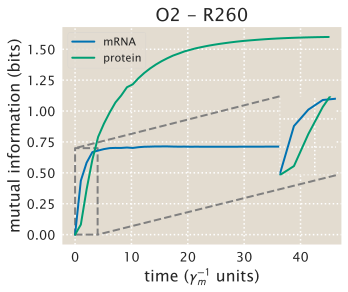

In [162]:
# Initialize figure
fig, ax = plt.subplots(figsize=(5, 4))
# Plot MI over time
ax.plot(time, MI.T)

# Label plot
ax.set_xlabel(r'time ($\gamma_m^{-1}$ units)')
ax.set_ylabel(r'mutual information (bits)')
ax.set_title('O2 - R260')
# Reduce margins
# ax.margins(0.01)

# Add zoom in plot
axins = zoomed_inset_axes(ax, 2.5, loc=5)
axins.plot(time, MI.T)
# Change aspect ratio of plot
axins.set_aspect(8)
# Set limits for plot
axins.set_xlim([0, 4])
axins.set_ylim([0, 0.7])
# Remove ticks
plt.xticks(visible=False)
plt.yticks(visible=False)
# Set fancy box that indicate zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="0.5", ec="0.5", lw=2,
           linestyle='--')


#Add legend
ax.legend(labels=['mRNA',  'protein'], loc='upper left')

# Save fig
plt.savefig(figdir + 'mutual_info_vs_time.pdf', bbox_inches='tight')